In [15]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pickle

years = np.arange(2008, 2016)
names = ['Attività e Passività', 'Costi e Ricavi', 'Entrate', 'Spese']

# Load Data

In [13]:
def create_data(dataframes, comuni, pop, category, features, lag, pred, mode, add = None):
	years = sorted(set(int(col.split('_')[1]) for col in dataframes.keys()))
	year_ranges = [np.arange(year, year + lag) for year in np.arange(years[0], years[-1] - lag + 2)]

	data = []
	y = []

	for year_range in year_ranges:
		data_temp = []
		for year in year_range:
			pop_temp = pop[f'pop_{year}'].values[:, np.newaxis]
			if mode == 'pop':
				temp = pd.concat([dataframes[f'{feature}_{year}_{category}'] for feature in features], axis=1) / pop_temp
			elif mode == 'abs':
				temp = pd.concat([dataframes[f'{feature}_{year}_{category}']
				                  .div(dataframes[f'{feature}_{year}_{category}'].sum(axis=1), axis=0).fillna(0)
				                  for feature in features], axis=1)
			if add is not None:
				for elem in add:
					if elem == 'pop':
						col = np.log(pop[f'pop_{year}'].copy())
						temp = pd.concat([temp, col], axis = 1)
					if elem == 'zone':
						for elem in zone.columns:
							col = zone[elem].copy()
							temp = pd.concat([temp, col], axis = 1)
			data_temp.append(temp)

		temp = np.stack([elem.values for elem in data_temp])
		temp = np.swapaxes(temp, 0, 1)
		data.append(temp)
		temp_y = sum([comuni[f'Target {year_range[-1] + i + 1}'].values for i in range(pred)])
		y.append((temp_y > 0).astype(int))

	X = np.concatenate(data)
	y = np.concatenate(y)
	print(X.shape)
				
	return X, y

In [23]:
columns = ['Denominazione', 'Dizione_Provincia', 'Dizione_Regione', 'Dizione_zona']

final = pd.read_csv('data//Anagrafe_comuni.csv', sep = ';', encoding = 'latin_1', low_memory = False).set_index('Id_Ente')

final['Data_Istituzione'] = pd.to_datetime(final['Data_Istituzione'], format='%Y-%m-%d')
final = final[final['Data_Istituzione'].dt.year < 2008]

final = final[final['Data_Cessazione'].isna()]

final = final[final['Codice_Tipologia_DLGS_118_2011'] == 'ELCOMU'][columns]

final = final.rename(columns={'Denominazione': 'Comune', 'Dizione_Provincia': 'Provincia', 'Dizione_Regione': 'Regione', 'Dizione_zona': 'Zona'})
final.index.names = ['BDAP']

final

,Comune,Provincia,Regione,Zona
BDAP,,,,
111142930451558302,COMUNE DI VERMIGLIO,TRENTO,TRENTINO-ALTO ADIGE/SÜDTIROL,NORD-EST
111142930456078402,COMUNE DI NARBOLIA,ORISTANO,SARDEGNA,ISOLE
111142930549694901,COMUNE DI RESANA,TREVISO,VENETO,NORD-EST
111242928159168602,COMUNE DI ALDINO,BOLZANO/BOZEN,TRENTINO-ALTO ADIGE/SÜDTIROL,NORD-EST
111342928035516202,COMUNE DI AUGUSTA,SIRACUSA,SICILIA,ISOLE
...,...,...,...,...
999842930521939101,COMUNE DI DOSOLO,MANTOVA,LOMBARDIA,NORD-OVEST
999842930529623202,COMUNE DI CESSOLE,ASTI,PIEMONTE,NORD-OVEST
999942930461543701,COMUNE DI BIENO,TRENTO,TRENTINO-ALTO ADIGE/SÜDTIROL,NORD-EST


In [17]:
dataframes = {}

for name in names:
	
    for year in years:
		
        for category in ["CAT I", "CAT II"]:
			
            file_path = f'data//{name} {year} {category}.pkl'
            df = pd.read_pickle(file_path)  
            dataframes[f'{name}_{year}_{category}'] = df

In [19]:
comuni = pd.read_pickle('data//comuni.pkl')
zone = pd.read_pickle('data//zona.pkl')
pop = pd.read_pickle('data//pop.pkl')
critici = pd.read_csv('data//CriticitàComuni.csv', sep = ';', low_memory = False)
for year in np.arange(2008, 2020):
	comuni[f'Target {year}'] = 0
for year in np.arange(2008, 2020):
	for idx, row in critici.iterrows():
		if int(row['Anno']) == year:
			comune = row['Comune']
			comune_2 = comune.replace('-', ' ')
			comuni.loc[(comuni['Comune'] == f'COMUNE DI {comune}') | (comuni['Comune'] == f'COMUNE DI {comune_2}'), f'Target {year}'] = 1

# Map

In [6]:
shapefile_path = "shapes//Com01012018_WGS84.shp" 
gdf = gpd.read_file(shapefile_path, encoding="utf-8")

In [7]:
anagrafe = pd.read_csv('data//Anagrafe_comuni.csv', sep = ';', encoding = 'latin_1', low_memory = False).set_index('Id_Ente')
anagrafe = anagrafe.loc[anagrafe['Codice_Tipologia_DLGS_118_2011'] == 'ELCOMU']

In [20]:
file1 = 'models_CAT I_final.pickle'
models = {}

with open(file1, 'rb') as f1:
    models['CAT I'] = pickle.load(f1)
model = models['CAT I'][3][8]['CNN']

category = 'CAT I'
features = names[2:4]
mode = 'pop'
add = ['pop', 'zone']

X, y = create_data(dataframes, comuni, pop, category, features, 8, 3, mode, add)
proba = model.predict(X)

(7773, 8, 18)
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [21]:
t = np.log(proba + 1e-6)
x = (t - np.min(t)) / (np.max(t) - np.min(t))

In [29]:
gdf

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_P_CM,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,4,0,4,4085,004085,Envie,None,0,22109.034867,2.493051e+07,22109.034867,"POLYGON ((373179.722 4952822.203, 373202.035 4..."
1,1,1,1,201,201,1216,001216,Rivara,None,0,27021.255667,1.258381e+07,27021.255667,"MULTIPOLYGON (((392240.121 5022530.683, 392249..."
2,1,1,4,0,4,4154,004154,Oncino,None,0,34457.558892,4.735918e+07,34457.558892,"POLYGON ((356215.447 4949975.718, 356247.447 4..."
3,1,1,4,0,4,4086,004086,Farigliano,None,0,28330.424944,1.644175e+07,28330.424944,"POLYGON ((413429.951 4933475.864, 413421.014 4..."
4,1,1,4,0,4,4116,004116,Manta,None,0,25177.109335,1.173446e+07,25177.109335,"MULTIPOLYGON (((381278.633 4942690.283, 381279..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,5,20,111,0,111,111009,111009,Carbonia,None,1,67398.804369,1.455415e+08,67398.804369,"POLYGON ((461403.79 4347922.873, 461454.79 434..."
7956,5,20,91,0,91,91039,091039,Loceri,None,0,36458.957282,1.937352e+07,36458.957282,"MULTIPOLYGON (((550582.075 4413538.342, 550596..."
7957,5,20,95,0,95,95083,095083,Magomadas,None,0,21155.082810,9.019823e+06,21155.082810,"POLYGON ((456480.817 4458012.992, 456512.817 4..."
7958,5,20,95,0,95,95067,095067,Tresnuraghes,None,0,35093.681593,3.158427e+07,35093.681593,"POLYGON ((459681.05 4456295.382, 459659.81 445..."


In [30]:
geo = pd.DataFrame(index = final.index)
geo["Codice_Istat"] = anagrafe.loc[geo.index, "Codice_ISTAT_Comune"]
geo['Probs'] = x
geo['Truth'] = y

In [31]:
gdf = gdf[["geometry", "PRO_COM"]].rename(columns={"PRO_COM": "Codice_Istat"})

gdf = gdf.merge(geo[["Codice_Istat", "Probs", "Truth"]], on="Codice_Istat", how="left")

gdf["Probs"] = gdf.apply(lambda row: -1 if row["Truth"] == 1 else row["Probs"], axis=1)

gdf = gdf.drop(columns=["Truth"])

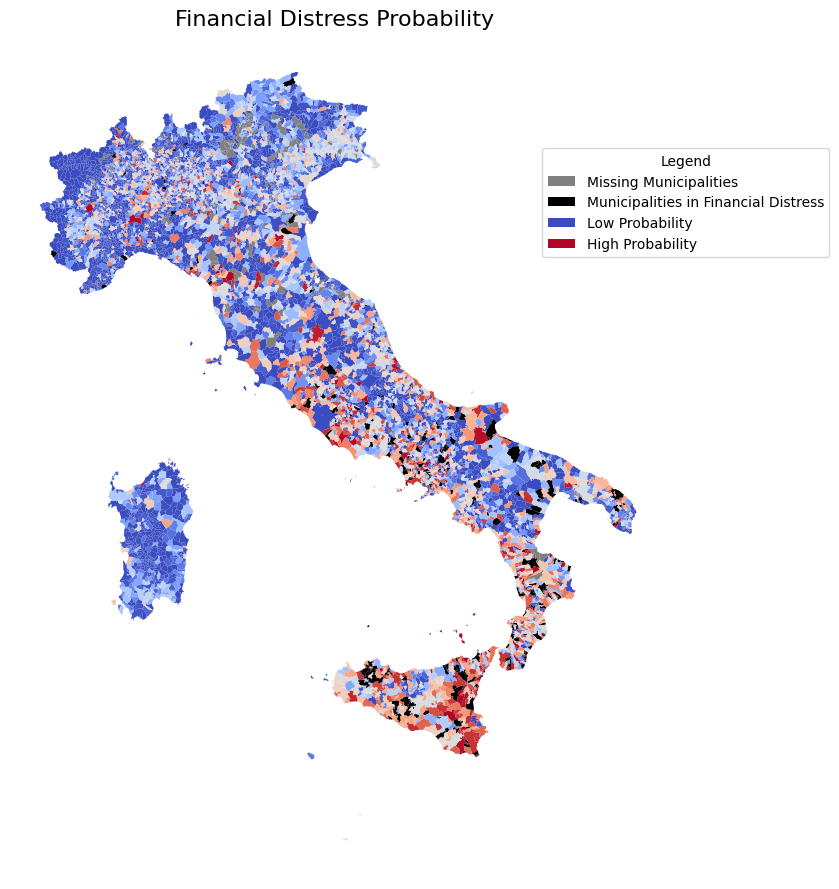

In [32]:
save = 0

na_color = "gray"
negative_one_color = "black" 

cmap = plt.cm.coolwarm 
norm = mcolors.Normalize(vmin=0, vmax=1)

gdf["color"] = gdf["Probs"].apply(lambda x: na_color if np.isnan(x) else (negative_one_color if x == -1 else cmap(norm(x))))

fig, ax = plt.subplots(1, 1, figsize=(10, 9))

gdf.plot(ax=ax, color=gdf["color"], edgecolor=None)

legend_elements = [
    Patch(facecolor=na_color, edgecolor='none', label='Missing Municipalities'),
    Patch(facecolor=negative_one_color, edgecolor='none', label='Municipalities in Financial Distress'),
    Patch(facecolor=cmap(0.0), edgecolor='none', label='Low Probability'),
    Patch(facecolor=cmap(1.0), edgecolor='none', label='High Probability'),
]
ax.legend(handles=legend_elements, title="Legend", fontsize=10, loc='center left', bbox_to_anchor=(0.8, 0.8))

plt.title("Financial Distress Probability ", fontsize=16)

ax.axis("off")

plt.tight_layout()

if save:
	plt.savefig('map.png')
plt.show()